### **Operations on New Virtual Machines**

#### Upgrade to Tensorflow 2.0, Install dependencies

In [0]:
# !pip install tensorflow-gpu
!pip install --no-dependencies image-classifiers

#### Test if GPU is available

In [0]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [0]:
# import tensorflow.keras.backend as K
# K.clear_session()
!nvidia-smi

Wed Dec 11 09:42:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |    265MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Mount with Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd "drive/My Drive/Colab Notebooks"

### **Program Codes Start Here**

In [0]:
# from architecture import TinyYoloNet
# from architecture import YoloMobileNet
# from architecture import YoloResNet18
from architecture import YoloNet

In [0]:
anchors = [0.64,1.13, 0.65,1.82, 0.91,1.51, 0.95,2.23, 1.05,1.10, 1.30,1.58, 1.39,2.32]

base_net = YoloNet(net_input_size=1056, 
                       anchors=anchors, 
                       n_class=1, 
                       weights_dir='',
                       labels=['bee-A'])

# base_net = YoloNet(net_input_size=1056, 
#                        anchors=anchors, 
#                         n_class=2, 
#                         weights_dir='', 
#                         labels=['bee-A', 'bee-B'])

feature_extractor = base_net.create_base_network(transfer_learning=False)

In [0]:
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1056, 1056,  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 1056, 1056, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 1056, 1056, 3 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1056, 1056, 3 0           norm_1[0][0]                     
______________________________________________________________________________________________

#### Load pretrained network model

In [0]:
from tensorflow.keras.models import load_model

base_net.create_model(feature_extractor)

model = load_model('Final Model Weights/fullyolo-1056-mardi-labelled-onetype1002-bee-model.h5', custom_objects={'custom_loss': base_net.custom_loss})
# model = load_model('Final Model Weights/fullyolo-noaug-1056-mardi-labelled-twotypes200-bee-model.h5', custom_objects={'custom_loss': base_net.custom_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1056, 1056, 3)]   0         
_________________________________________________________________
model (Model)                (None, 33, 33, 1024)      50547936  
_________________________________________________________________
DetectionLayer (Conv2D)      (None, 33, 33, 49)        50225     
_________________________________________________________________
reshape (Reshape)            (None, 33, 33, 7, 7)      0         
Total params: 50,598,161
Trainable params: 50,577,489
Non-trainable params: 20,672
_________________________________________________________________


### **Make predictions and visualization**

In [0]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import imutils
import math
import os

#### Save video to frames of images

In [0]:
folder_name = 'FHD0003-frames'
vidcap = cv2.VideoCapture('Demo Samples/FHD0003.MOV')
count = 0

fps = int(vidcap.get(cv2.CAP_PROP_FPS))

i =  0
second = 0

success, frame = vidcap.read()

print(success)
while(success):
    success, image = vidcap.read()    
    if count % (fps//2) == 0:
        print(second)
        second += 1

    if count % (math.ceil(fps / 2)) == 0 :
        cv2.imwrite('Demo Samples/' + folder_name + '/test-frame-%d.jpg' % i, image)
        print('Saved test-frame-%d.jpg' % i)
        i += 1
    count += 1

vidcap.release()

#### Make predictions - single image

/content/drive/My Drive/Colab Notebooks/utils.py:25: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


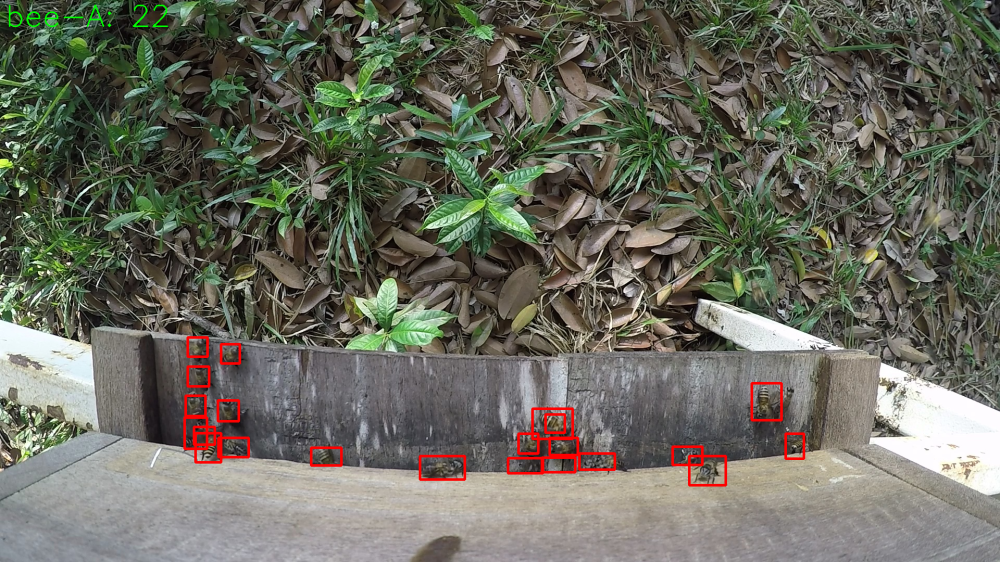

In [0]:

# image = cv2.imread('Demo Samples/B-frame-130.jpg')
image = cv2.imread('Demo Samples/Copy of frame-269.jpg')
prediction_info = base_net.predict_boxes(model, image, 0.05, 0.3)

image = imutils.resize(image, width=1000)

cv2_imshow(image)

In [0]:
prediction_info

#### Make predictions - video frames

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
folder_name = 'FHD0003-frames'

all_imgs = os.listdir('Demo Samples/'+folder_name)

count_list_total = []
count_list_A = []
count_list_B = []

x_A = []
y_A = []
x_B = []
y_B = []

for img in all_imgs:
    print('Processing ' + img)
    image = cv2.imread('Demo Samples/' + folder_name + '/' +img)
    
    prediction_info = base_net.predict_boxes(model, image, 0.09, 0.2)
    print(prediction_info)

    count_list_total.append(prediction_info['total_count'])
    count_list_A.append(len(prediction_info['coords'][0]))
    count_list_B.append(len(prediction_info['coords'][1]))

    for c in prediction_info['coords'][0]:
        x_A.append(c[0])
        y_A.append(c[1])
        
    for c in prediction_info['coords'][1]:
        x_B.append(c[0])
        y_B.append(c[1])

Processing test-frame-200.jpg
{'coords': {0: [(554, 277), (719, 280), (1551, 279), (1061, 322), (1252, 318), (157, 352), (308, 346), (845, 355), (1467, 350), (745, 382), (1190, 375), (225, 407), (356, 404), (420, 404), (1252, 413), (1672, 419), (311, 451), (703, 443), (63, 473), (301, 502), (82, 550), (769, 528), (856, 551), (1352, 550), (626, 567), (1250, 580), (271, 602), (495, 610), (604, 616), (1026, 611), (1156, 611), (1310, 617), (1500, 601), (773, 632)], 1: []}, 'total_count': 34, 'count_dict': {0: 34, 1: 0}}
Processing test-frame-201.jpg
{'coords': {0: [(794, 115), (1418, 224), (720, 279), (1558, 277), (854, 318), (1353, 314), (1070, 332), (1485, 355), (744, 382), (1254, 375), (225, 406), (363, 406), (425, 403), (1172, 395), (1671, 419), (280, 441), (702, 443), (59, 481), (309, 504), (859, 517), (1310, 497), (85, 537), (775, 538), (630, 561), (1256, 575), (255, 600), (550, 616), (1025, 611), (1157, 611), (1304, 614), (1500, 599), (1641, 595), (490, 630), (777, 631)], 1: []}, 't

#### Generate Frequency Graph

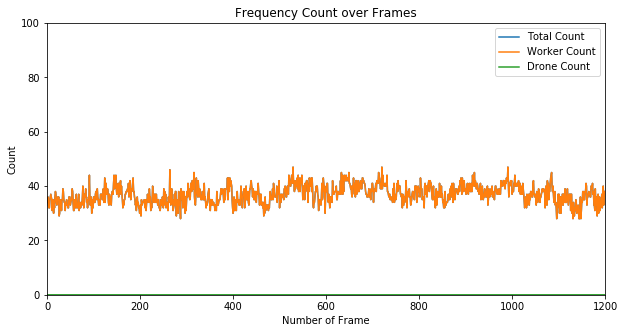

In [0]:
plt.rcParams['figure.figsize'] = [10, 5]


x1,x2,y1,y2 = plt.axis()
plt.axis((0,len(count_list_total),0,100))

plt.plot(count_list_total, label='Total Count')
plt.plot(count_list_A, label='Worker Count')
plt.plot(count_list_B, label='Drone Count')

plt.title('Frequency Count over Frames')
plt.xlabel('Number of Frames')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

#### Generate Frequency Heat Map

In [0]:
import numpy as np
from scipy.stats.kde import gaussian_kde

In [0]:
x_all = x_A + x_B
y_all = y_A + y_B

x = np.array(x_all)
y = np.array(y_all)

y = 1080 - y

In [0]:
y.shape

(44269,)

In [0]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

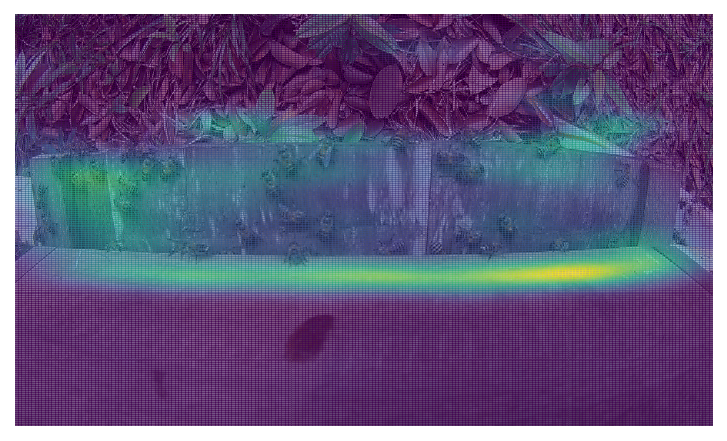

In [0]:
# plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure(figsize=(6,8), dpi=150)
ax1 = fig.add_subplot(211)

# alpha=0.5 will make the plots semitransparent
ax1.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.5)

# ax1.set_xlim(x.min(), x.max())
# ax1.set_ylim(y.min(), y.max())

# you can also overlay your soccer field
im = plt.imread('Demo Samples/'+ folder_name + '/' + all_imgs[0])
ax1.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

plt.axis('off') 
plt.show()